In [3]:
# aivietnam.ai
# sum-area table ; simple implementation

# Chương trình này bên C++ có thể đạt real-time nếu tối ưu hơn ở vài chỗ.
# Bên python không thiết kế để thao tác đến từng vị trí và tối ưu cho việc dùng vectorization.
# Chúng ta thấy rõ hơn tác dùng của sum-area table bên stereo_matching_ad (file SumAreaTable). 

import numpy as np
from PIL import Image
import math

def stereo_matching_corr(left_img, right_img, kernel_size, disparity_range):
   
    # đọc ảnh trái và ảnh phải, rồi chuyển sang ảnh grayscale
    left_img  = Image.open(left_img).convert('L')
    left      = np.asarray(left_img)
    
    right_img = Image.open(right_img).convert('L')
    right     = np.asarray(right_img) 
       
    # cho trước chiều rộng và chiều cao của ảnh
    height = 370 #288
    width  = 427 #384
    
    # tạo disparity map
    depth = np.zeros((height, width), np.uint8)   
    
    # số lượng pixel trong một window
    n = kernel_size*kernel_size
    
    # kernel_half để bỏ rìa (viền) xung quanh
    kernel_half = int( (kernel_size-1) / 2)  
    
    # giá trị scale chỉ có tác dụng để làm disparity map nhìn rõ ràng hơn.
    scale = 255 / disparity_range
    
    # lưu tất cả các giá trị corr cho mỗi pixep p bên ảnh trái và D (disaprity range) pixel q bên ảnh phải
    corr_space = np.ones((disparity_range, height, width))
    
    # build sum-area table for each disparity    
    for j in range(disparity_range):
        print(".", end=" ")
        
        # Dựa vào công thức tính corr, có 5 loại tính sum.
        # Do đó, có 5 nhóm biến khác nhau cho việc tính sum này
        
        # memory là các sum-area table. Khởi tạo với các giá trị 1 không có ý nghĩa gì cả. 
        memory_sum_x  = np.ones((height, width))
        memory_sum_y  = np.ones((height, width))
        memory_sum_xy = np.ones((height, width))
        memory_sum_x2 = np.ones((height, width))
        memory_sum_y2 = np.ones((height, width))
    
        # các biến data chứa 5 kiểu data để tính sum. Khởi tạo với các giá trị 1 không có ý nghĩa gì cả.
        # Gán giá trị khởi tạo cho các vị trí. 255 cho x và 1 cho y. Các giá trị này có ý nghĩa cho các vị trí rìa.
        data_sum_x  = np.ones((height, width))*255
        data_sum_y  = np.ones((height, width))
        data_sum_xy = np.ones((height, width))*255
        data_sum_x2 = np.ones((height, width))*255*255
        data_sum_y2 = np.ones((height, width))
        
        for y in range(kernel_half, height-kernel_half):
            for x in range(kernel_half, width-kernel_half):
                if (x - j >= 0):
                    data_sum_x[y, x]  = int(left[y, x])
                    data_sum_y[y, x]  = int(right[y, x - j])
                    data_sum_xy[y, x] = int(left[y, x])*int(right[y, x - j])
                    data_sum_x2[y, x] = int(left[y, x])*int(left[y, x])
                    data_sum_y2[y, x] = int(right[y, x - j])*int(right[y, x - j])
        
        # bắt đầu tính sum-area table
        # Các bạn xem cách thuật toán hoạt động ở đây nhé https://en.wikipedia.org/wiki/Summed-area_table
        
        # first item
        memory_sum_x[0, 0]  = data_sum_x[0, 0]
        memory_sum_y[0, 0]  = data_sum_y[0, 0]
        memory_sum_xy[0, 0] = data_sum_xy[0, 0]
        memory_sum_x2[0, 0] = data_sum_x2[0, 0]
        memory_sum_y2[0, 0] = data_sum_y2[0, 0]
    
        # first row
        for y in range(1):
            for x in range(1, width):
                memory_sum_x[y, x]  = memory_sum_x[y, x - 1] + data_sum_x[y, x]
                memory_sum_y[y, x]  = memory_sum_y[y, x - 1] + data_sum_y[y, x]
                memory_sum_xy[y, x] = memory_sum_xy[y, x - 1] + data_sum_xy[y, x]
                memory_sum_x2[y, x] = memory_sum_x2[y, x - 1] + data_sum_x2[y, x]
                memory_sum_y2[y, x] = memory_sum_y2[y, x - 1] + data_sum_y2[y, x]
                    

        # first column
        for x in range(1):
            for y in range(1, height):
                memory_sum_x[y, x]  = memory_sum_x[y - 1, x] + data_sum_x[y, x]
                memory_sum_y[y, x]  = memory_sum_y[y - 1, x] + data_sum_y[y, x]
                memory_sum_xy[y, x] = memory_sum_xy[y - 1, x] + data_sum_xy[y, x]
                memory_sum_x2[y, x] = memory_sum_x2[y - 1, x] + data_sum_x2[y, x]
                memory_sum_y2[y, x] = memory_sum_y2[y - 1, x] + data_sum_y2[y, x]
        
        # remaining
        for y in range(1, height): 
            for x in range(1, width):
                memory_sum_x[y, x]  = memory_sum_x[y, x - 1] + memory_sum_x[y - 1, x] - \
                                      memory_sum_x[y - 1, x - 1] + data_sum_x[y, x] 
                memory_sum_y[y, x]  = memory_sum_y[y, x - 1] + memory_sum_y[y - 1, x] - \
                                      memory_sum_y[y - 1, x - 1] + data_sum_y[y, x]
                memory_sum_xy[y, x] = memory_sum_xy[y, x - 1] + memory_sum_xy[y - 1, x] - \
                                      memory_sum_xy[y - 1, x - 1] + data_sum_xy[y, x]
                memory_sum_x2[y, x] = memory_sum_x2[y, x - 1] + memory_sum_x2[y - 1, x] - \
                                      memory_sum_x2[y - 1, x - 1] + data_sum_x2[y, x]
                memory_sum_y2[y, x] = memory_sum_y2[y, x - 1] + memory_sum_y2[y - 1, x] - \
                                      memory_sum_y2[y - 1, x - 1] + data_sum_y2[y, x]
    
        # Tính corr cho một giá trị j
        for y in range(kernel_half, height-kernel_half):        
            for x in range(kernel_half, width-kernel_half):
                
                # xác định window để tính sum
                x0 = x - kernel_half
                x1 = x + kernel_half                
                y0 = y - kernel_half
                y1 = y + kernel_half
                
                # tính sum dựa vào 4 giá trị từ table
                # tính sum cho 5 loại (dựa vào công thức correlation coefficient)
                # Dấu \ cho phép code xuống hàng; không có ý nghĩa gì cho tính logic của chương trình.
                
                # chỗ này cần thêm ràng buộc khi x0,y0=0
                
                sum_x = memory_sum_x[y1, x1] - memory_sum_x[y1, x0 - 1] - \
                        memory_sum_x[y0 - 1, x1] + memory_sum_x[y0 - 1, x0 - 1]
                
                sum_y = memory_sum_y[y1, x1] - memory_sum_y[y1, x0 - 1] - \
                        memory_sum_y[y0 - 1, x1] + memory_sum_y[y0 - 1, x0 - 1]
                
                sum_xy = memory_sum_xy[y1, x1] - memory_sum_xy[y1, x0 - 1] - \
                         memory_sum_xy[y0 - 1, x1] + memory_sum_xy[y0 - 1, x0 - 1]
                
                sum_x2 = memory_sum_x2[y1, x1] - memory_sum_x2[y1, x0 - 1] - \
                         memory_sum_x2[y0 - 1, x1] + memory_sum_x2[y0 - 1, x0 - 1]
                
                sum_y2 = memory_sum_y2[y1, x1] - memory_sum_y2[y1, x0 - 1] - \
                         memory_sum_y2[y0 - 1, x1] + memory_sum_y2[y0 - 1, x0 - 1]
                
                # tính correlation coefficient              
                corr = (n*sum_xy - sum_x*sum_y) / \
                       (np.sqrt(n*sum_x2 - sum_x**2) * np.sqrt(n*sum_y2 - sum_y**2))
                
                # có corr càng lớn càng tốt và -1 <= corr < = 1
                # Do đó, chúng ta cần chuyển corr thành dạng loss (hay error)
                corr_space[j, y, x] = 1.0 - corr
                
    
    # Khi chương trình chạy tới đây. corr_space đã được tính xong; 
    # mỗi pixel p bên ảnh trái có D giá trị cost với D pixel bên ảnh phải
    
    # Tìm j, tại đó cost có giá trị min. Nói cách khác, trong D giá trị cost, trình vị trí disparity có cost nhỏ nhất
    for y in range(kernel_half, height-kernel_half):        
        for x in range(kernel_half, width-kernel_half):
            disparity = 0
            cost_min  = 1.0 # a large number            
            for j in range(disparity_range):
                cost = corr_space[j, y, x]                                
                if cost < cost_min:
                    cost_min = cost
                    disparity = j                  
            
            # gán j cho cost_min vào disaprity map
            depth[y, x] = int(disparity * scale)
                                
    # chuyển dữ liệu từ ndarray sang kiểu Image và lưu xuống file
    Image.fromarray(depth).save('Aloe_disparity_map_corr.png')
 

disparity_range = 64 # cho cặp ảnh Tsukuba
kernel_size = 11
stereo_matching_corr("Aloe_left_1.png", "Aloe_right_2.png", kernel_size, disparity_range)

. 

C:\Users\dinhvinh\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in sqrt


. . . . . . . . . . . . 

C:\Users\dinhvinh\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

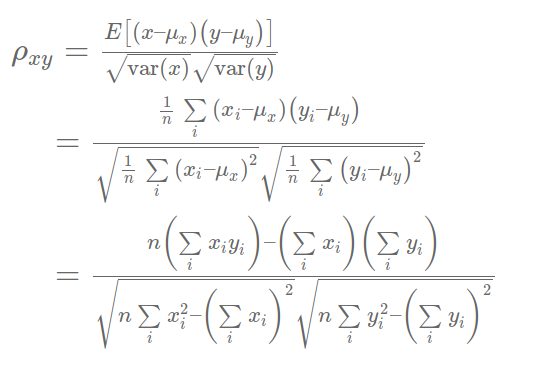